In [27]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

Initializing the ViT Model

In [31]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Adding Additional layers on top of ViT Model

In [32]:
model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               98432     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 layer_normalization_2 (Laye  (None, 128)              256       
 rNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                

In [33]:
#Function for focal loss
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Compiling model using focal loss and Adam optimiser
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

Function for plotting the graph of Train and Validation Accuracy and loss

In [35]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

   #Plot Train and Validation Accuracy
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  #Plot Train and Validation Loss
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [55]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculate ROC score

    # Calculate confusion matrix CHANGE THIS TO CM
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = cm[1,1] / (cm[1,1] + cm[0,1])
    specificity = cm[1,1] / (cm[1,1] + cm[1,0])
    
    total=sum(sum(cm))
    accuracy=(cm[0,0]+cm[1,1])/total
    print ('Accuracy : ', accuracy)

    report = classification_report(test_labels, predicted_labels) #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #Calculate Precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [37]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/kaggle/input/isic-train-merge-aug/train_augumented-2023/train_augumented/task1"
test_dir = "/kaggle/input/isic-train-merge-aug/test2023/test/task1"
val_dir = "/kaggle/input/isic-train-merge-aug/val-2023/val/task1"

In [38]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 32

Creating batches to improve memory optimization

In [40]:
train_batches = datagen.flow_from_directory(train_dir,
                                            target_size=(image_size),
                                            batch_size=10,
                                           classes=['nevus_seb', 'mel'])

valid_batches = datagen.flow_from_directory(val_dir,
                                            target_size=(image_size),
                                            batch_size=10,
                                           classes=['nevus_seb', 'mel'])

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_dir,
                                            target_size=(image_size),
                                            batch_size=1,
                                            shuffle = False,
                                           classes=['nevus_seb', 'mel'])

Found 12000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [41]:
train_batches.class_indices

{'nevus_seb': 0, 'mel': 1}

In [42]:
valid_batches.class_indices

{'nevus_seb': 0, 'mel': 1}

In [43]:
from collections import Counter

class_counts = Counter(train_batches.classes)
print("Number of images per class:", class_counts)


Number of images per class: Counter({0: 9756, 1: 2244})


In [44]:
class_names = list(train_batches.class_indices.keys())
class_counts_with_names = {class_names[idx]: count for idx, count in class_counts.items()}
print("Number of images per class:", class_counts_with_names)

Number of images per class: {'nevus_seb': 9756, 'mel': 2244}


In [45]:
train_steps = np.ceil(train_batches.n / batch)
test_steps = np.ceil(test_batches.n / batch)
val_steps = np.ceil(valid_batches.n / batch)

Configuration of Early stopping criteria, learning rate

In [46]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4)  #Configuring early stopping criteria

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')
#Configure dynamic learning rate
def step_decay(epoch):
    initial_lrate = 0.00002
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [47]:
callbacks = [early_stopping, checkpointer, lr_scheduler]

Model Training

In [48]:
history = model.fit(train_batches, steps_per_epoch=train_steps,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=20,
                              callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/20
375/375 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.7739
Epoch 1: val_accuracy improved from -inf to 0.84000, saving model to model.hdf5
375/375 [==============================] - 153s 281ms/step - loss: 0.0531 - accuracy: 0.7739 - val_loss: 0.0424 - val_accuracy: 0.8400 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.8272
Epoch 2: val_accuracy did not improve from 0.84000
375/375 [==============================] - 102s 271ms/step - loss: 0.0378 - accuracy: 0.8272 - val_loss: 0.0591 - val_accuracy: 0.7000 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2e-05.
Epoch 3/20
375/375 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.8475
Epoch 3: val_accuracy improved from 0.84000 to 0.86000, saving model to model.hdf5
37

In [49]:
model.load_weights(filepath = '/kaggle/working/model.hdf5')

In [50]:
test_results = model.evaluate(test_batches, steps=600, verbose=1)

600/600 [==============================] - 20s 33ms/step - loss: 0.0359 - accuracy: 0.8550


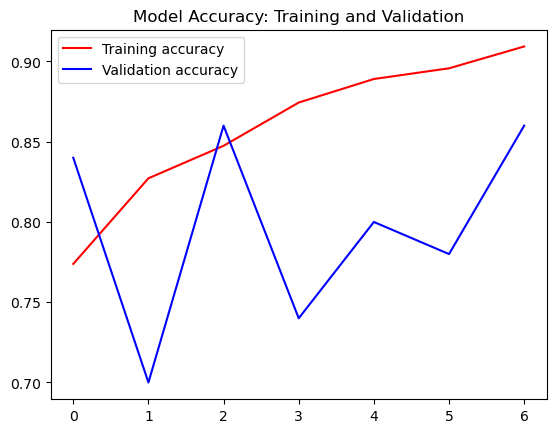

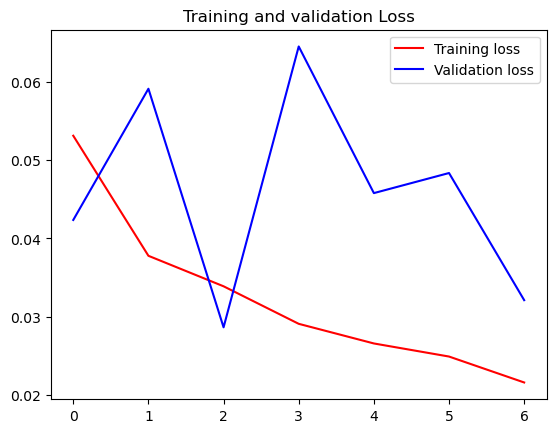

<Figure size 640x480 with 0 Axes>

In [51]:
graph_it(history)

**Model Evaluation using test data**

600/600 [==============================] - 20s 33ms/step


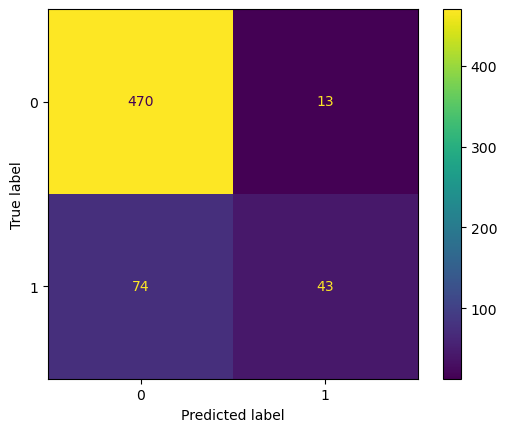

Accuracy :  0.855

               precision    recall  f1-score   support

           0       0.86      0.97      0.92       483
           1       0.77      0.37      0.50       117

    accuracy                           0.85       600
   macro avg       0.82      0.67      0.71       600
weighted avg       0.85      0.85      0.83       600

Sensitivity: 0.768 Specificity: 0.368 Precision: 0.845 ROC_AUC_SCORE: 0.83



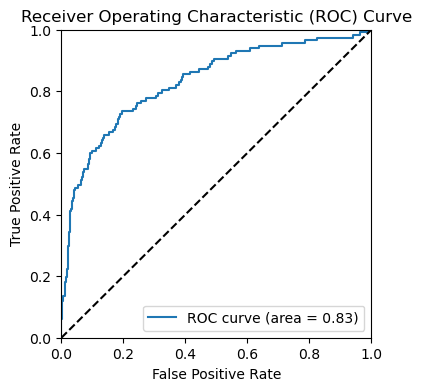

In [56]:
model.load_weights(filepath = 'model.hdf5')
test_it(model, test_batches)